### LSTM

In [5]:
import pandas as pd
import numpy as np
data = pd.read_csv('../data/BTC-I.csv', parse_dates=['Date'], index_col=['Date'])
data

,Close,High,Low,Open,Volume,ema20,ema50,rsi10,rsi30,rsi200,macd,signal,hist,Price-Up
Date,,,,,,,,,,,,,,
2015-04-04,253.697006,255.257996,251.100006,254.291000,12493500,255.661524,258.734938,48.021982,48.257672,45.132844,-4.193133,-3.906538,-0.286595,1
2015-04-05,260.597992,260.674988,251.942001,253.761002,19649200,256.131663,258.807999,55.322540,50.163041,45.493022,-3.252122,-3.775655,0.523533,0
2015-04-06,255.492004,261.798004,254.574997,260.721008,20034200,256.070744,258.677960,49.595801,48.787931,45.272028,-2.885117,-3.597547,0.712430,0
2015-04-07,253.179993,255.804993,252.205002,255.274002,18467400,255.795434,258.462354,47.140702,48.169404,45.172167,-2.749132,-3.427864,0.678732,0
2015-04-08,245.022003,253.847000,244.214996,253.063995,30086400,254.769393,257.935281,39.478769,46.038877,44.821560,-3.262042,-3.394700,0.132658,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-01,113320.085938,116060.773438,112724.445312,115738.953125,91294530181,116502.611153,112886.866523,34.256080,52.122739,54.392931,1081.591121,1948.832592,-867.241471,0
2025-08-02,112526.914062,114021.601562,112005.765625,113320.390625,56870866000,116123.973335,112872.750740,31.828916,50.976726,54.238696,650.369320,1689.139937,-1038.770617,1
2025-08-03,114217.671875,114747.421875,111943.804688,112525.804688,48099615826,115942.420815,112925.492746,41.625144,53.243667,54.515007,439.981133,1439.308177,-999.327043,1


In [16]:
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'ema20', 'ema50', 'rsi10', 'rsi30', 'rsi200', 'macd', 'signal', 'hist']
target = ['Price-Up']
# Separar X e y
X = data[features]
y = data[target].to_numpy()
X.shape, y.shape


((3777, 13), (3777, 1))

In [25]:
sequence_length = 30 
X_sequences = []
y_sequences = []
for i in range(sequence_length, len(X)): 
    X_sequences.append(X[i - sequence_length: i])
    y_sequences.append(y[i])
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)
X_sequences.shape, y_sequences.shape
#Aca optenemos la (cantidad de secuencias(ventanas), cantidad de dias, cantidad de features)

((3747, 30, 13), (3747, 1))

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X) 
X_scaled.shape, X_scaled

((3555, 6),
 array([[-0.99905404, -0.9994717 , -0.99945855, -0.11622951, -0.16545748,
         -0.18370997],
        [-0.99915044, -0.99947293, -0.99946135, -0.15664954, -0.16539683,
         -0.18367719],
        [-0.99919409, -0.99947847, -0.99946599, -0.17483236, -0.16537436,
         -0.18364596],
        ...,
        [ 0.87083169,  0.97606199,  0.99684566,  0.11835793, -0.01399826,
          0.15477139],
        [ 0.80468091,  0.9710016 ,  0.99921407,  0.00720157, -0.06251236,
          0.11002468],
        [ 0.77136738,  0.96304186,  1.        , -0.04517783, -0.12494937,
          0.06031991]], shape=(3555, 6)))

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.1, shuffle=False)

### Pytorch Implementation

In [27]:
import torch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape 

(torch.Size([3172, 30, 6]),
 torch.Size([353, 30, 6]),
 torch.Size([3172, 1]),
 torch.Size([353, 1]))

In [28]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor) # Instanciamos la clase TendorDataSet 
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size, shuffle=True) # Instanciamos la clase DataLoader
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

print(len(train_loader))
for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)
      # Solo el primer batch
    break


100
Batch X shape: torch.Size([32, 30, 6])
Batch y shape: torch.Size([32, 1])


In [29]:
import torch
import torch.nn as nn 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device)

class MiLSTM (nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size ):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        # Definimos 1 capa LSTM y un Full Connected 
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) #Ej [8, 64, 2, (batch_size, seq_length, hidden_size)]
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # h0 y c0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Ej [2, 32, 64]
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # Ej [2, 32, 64]

        # Layer LSTM 
        out, _ = self.lstm(x, (h0,c0)) 

        
        out = out[:,-1,:] 

        #Pasa por la fc
        out = self.fc(out) 

        return out

# Parameters of the model 
input_size = X_train_tensor.shape[2] 
hidden_size = 128
num_layers  = 4
output_size = 1 # Classification 

model = MiLSTM(input_size, hidden_size, num_layers, output_size).to(device)
print(model) 

cuda
MiLSTM(
  (lstm): LSTM(6, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
num_epochs = 100 
model.train()
print(f'Entrenado en {device}')

for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device) #[32, 30, 8]
        batch_y = batch_y.to(device) #[32, 1]

        outputs = model(batch_X).squeeze() # [batch_size, 1] => [batch_size] 

        loss = criterion(outputs, batch_y.squeeze())

        loss.backward()

        optimizer.step()

        optimizer.zero_grad()
    if (epoch + 1 ) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')





Entrenado en cuda
Epoch [10/100], Loss: 0.6310
Epoch [20/100], Loss: 0.6958
Epoch [30/100], Loss: 0.7275
Epoch [40/100], Loss: 0.6189
Epoch [50/100], Loss: 0.6673
Epoch [60/100], Loss: 0.7244
Epoch [70/100], Loss: 0.6947
Epoch [80/100], Loss: 0.6950
Epoch [90/100], Loss: 0.6225
Epoch [100/100], Loss: 0.6948


In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch
import numpy as np

model.eval()  # Modo de evaluación
y_true = []  # Etiquetas reales
y_pred = []  # Predicciones binarias
y_probs = []  # Probabilidades predichas

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_X).squeeze()   # Logits
        probs = torch.sigmoid(outputs)       # Probabilidades
        predicted = torch.round(probs)       # Predicciones binarias (0 o 1)

        # Guardar los valores reales y predichos
        y_true.extend(batch_y.view(-1).cpu().numpy())  # Solución aquí ✅
        y_pred.extend(predicted.view(-1).cpu().numpy())
        y_probs.extend(probs.view(-1).cpu().numpy())

# Convertir listas a numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

# Calcular métricas
accuracy = np.mean(y_pred == y_true) * 100
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_probs)

# Mostrar resultados
print(f'Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')


Accuracy: 52.12%
Precision: 0.52
Recall: 1.00
F1-Score: 0.69
ROC-AUC: 0.50


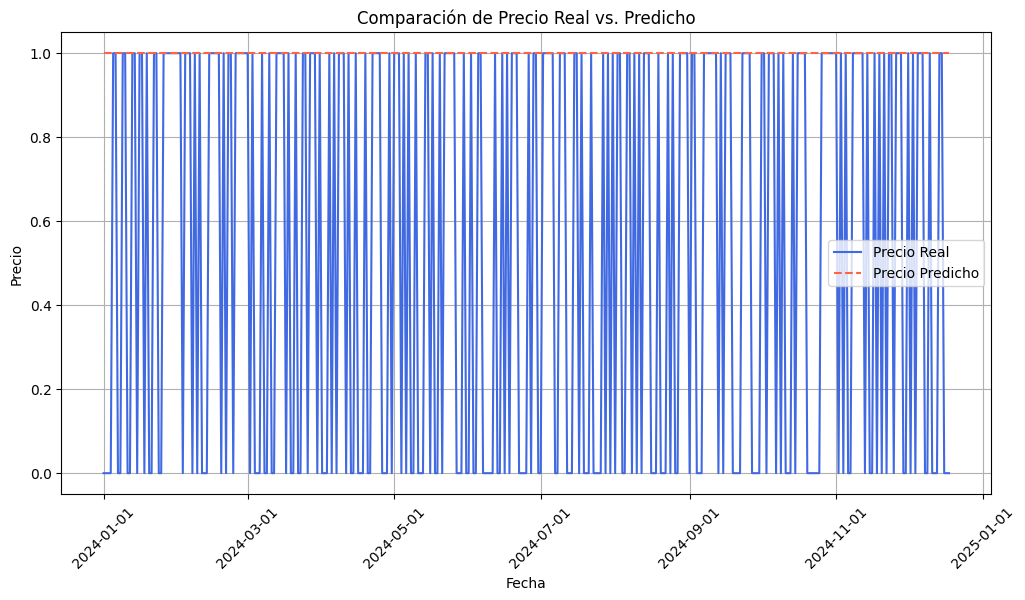

In [37]:
import matplotlib.dates as mdates
import pandas as pd

# Suponiendo que tienes un DataFrame con fechas
fechas = pd.date_range(start="2024-01-01", periods=len(y_true), freq="D")

plt.figure(figsize=(12, 6))
plt.plot(fechas, y_true, label="Precio Real", color='royalblue')
plt.plot(fechas, y_pred, label="Precio Predicho", color='tomato', linestyle='dashed')

# Mejorar formato de fechas
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato Año-Mes-Día
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto-ajuste de fechas

plt.xticks(rotation=45)  # Rotar etiquetas para mejor visibilidad
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.title("Comparación de Precio Real vs. Predicho")
plt.legend()
plt.grid(True)

plt.show()
